In [54]:
import collections
import math

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

sns.set(style='dark', font_scale=2, palette='colorblind')

In [124]:
world_bank_path = 'data/world_bank_financial_data.csv'
imf_path = 'data/imf_financial_data.csv'
tax_world_bank_path = 'data/world_bank_tax.csv'

main_indicators = ['GGXWDG_NGDP', 'GFDD.SI.02', 'NID_NGDP'] #'SI.POV.DDAY'
countries = {
    'france': {
        'name': 'France',
        'iso2': 'FR',
        'iso3': 'FRA',
        'color': (0.0, 0.4470588235294118, 0.6980392156862745),
    },
    'germany': {
        'name': 'Germany',
        'iso2': 'DE',
        'iso3': 'DEU',
        'color': '#BDA800',
    },
    'greece': {
        'name': 'Greece',
        'iso2': 'GR',
        'iso3': 'GRC',
        'color': (0.8352941176470589, 0.3686274509803922, 0.0),
    },
    'ireland': {
        'name': 'Ireland',
        'iso2': 'IE',
        'iso3': 'IRL',
        'color': (0.0, 0.6196078431372549, 0.45098039215686275),
    },
    'italy': {
        'name': 'Italy',
        'iso2': 'IT',
        'iso3': 'ITA',
        'color': (0.8, 0.4745098039215686, 0.6549019607843137),
    },
    'netherlands': {
        'name': 'Netherlands',
        'iso2': 'NL',
        'iso3': 'NLD',
        'color': '#2A282C',
    },
    'portugal': {
        'name': 'Portugal',
        'iso2': 'PT',
        'iso3': 'PRT',
        'color': '#800000',
    },
    'spain': {
        'name': 'Spain',
        'iso2': 'ES',
        'iso3': 'ESP',
        'color': (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
    },
}
countries_iso3 = sorted([c['iso3'] for c in countries.values()])

DEFAULT_DATERANGE = (1998, 2018)

In [125]:
world_bank_data = pd.read_csv(world_bank_path)
world_bank_data['Source'] = world_bank_data.apply(lambda r: 'World Bank', axis=1)

world_bank_tax_data = pd.read_csv(tax_world_bank_path)
world_bank_tax_data['Source'] = world_bank_tax_data.apply(lambda r: 'World Bank', axis=1)

world_bank_poverty_data = pd.read_csv('data/world_bank_poverty.csv')
world_bank_poverty_data['Source'] = world_bank_poverty_data.apply(lambda r: 'World Bank', axis=1)

In [126]:
def parse_number(v):
    try:
        return float(v.replace(',', '').strip())
    except ValueError:
        return float('NaN')

float_columns = [
    '1980', '1981', '1982', '1983', '1984',
    '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
    '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
    '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
    '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
    '2021', '2022', '2023', 'Estimates Start After'
]
converters = {col: parse_number for col in float_columns}
imf_data = pd.read_csv(imf_path, converters=converters)

imf_data['Indicator Code'] = imf_data['WEO Subject Code']
imf_data['Indicator Name'] = imf_data.apply(
    lambda r: '{} ({})'.format(r['Subject Descriptor'], r['Units']), 
    axis=1
)
imf_data['Country Code'] = imf_data['ISO']
imf_data['Country Name'] = imf_data['Country']
imf_data['Source'] = imf_data.apply(lambda r: 'IMF', axis=1)

In [127]:
def max_int_column(data):
    years = []
    for c in data.columns:
        try:
            years.append(int(c))
        except ValueError:
            pass
        
    return max(years)

def get_data(indicators):
    world_bank = get_dataset(world_bank_data, indicators, countries_iso3)
    world_bank_tax = get_dataset(world_bank_tax_data, indicators, countries_iso3)
    world_bank_poverty = get_dataset(world_bank_poverty_data, indicators, countries_iso3)
    imf = get_dataset(imf_data, indicators, countries_iso3)
    return (
        world_bank.append(world_bank_tax, sort=True).append(world_bank_poverty_data, sort=True).append(imf, sort=True)
    )

def get_dataset(data, indicators, countries_ios3, date_range=DEFAULT_DATERANGE):
    df = data[
        (data['Indicator Code'].isin(indicators)) &
        (data['Country Code'].isin(countries_ios3))
    ].reset_index()
    
    relevant_columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Source']
    max_range = min(date_range[-1], max_int_column(data))
    relevant_columns += [str(v) for v in range(date_range[0], max_range + 1, 1)]
    
    return df[relevant_columns]

In [158]:
def mention(ax, source, position=None):
    if position is None:
        position = (0.01, 0.01)
        
    ax.text(
        position[0], 
        position[1], 
        'romainstrock.com - data © {}'.format(source),
        verticalalignment='bottom', 
        horizontalalignment='left',
        transform=ax.transAxes,
        color='grey',
        fontsize=14,
    )
    

def plot_indicator(ax, data, indicator_code, countries, date_range=DEFAULT_DATERANGE):
    df = data[data['Indicator Code'] == indicator_code]
        
    title = df.iloc[0]['Indicator Name']
    source = df.iloc[0]['Source']
    ax.set_title(title)

    max_range = min(date_range[-1], max_int_column(df))
    dates_num = [v for v in range(date_range[0], max_range + 1, 1)]
    date_columns = [str(v) for v in dates_num]
    dates = [pd.Timestamp(year, 1, 1) for year in dates_num]

    for country in countries.values():
        country_serie = df[df['Country Code'] == country['iso3']].iloc[0]
        y = [country_serie[col] for col in date_columns]

        marker = None
        if country['name'] == 'Greece':
            marker='o'

        color = None
        if country.get('color'):
            color = country['color']

        ax.plot(dates, y, label=country['name'], marker=marker, color=color)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
    
    if source == 'IMF':
        mention_position = (0.825, 0.01)
    elif source == 'World Bank':
        mention_position = (0.78, 0.01)
    else:
        mention_position = None
    
    mention(ax, source, position=mention_position)
    # mention(ax, source, position=(0.02, 0.01))


def plot_indicators(data, indicator_codes, countries, date_range=DEFAULT_DATERANGE):
    f, axes = plt.subplots(len(indicator_codes), figsize=(20, 11 * len(indicator_codes)))

    for i, indicator_code in enumerate(indicator_codes):
        if len(indicator_codes) == 1:
            ax = axes
        else:
            ax = axes[i]
            
        plot_indicator(ax, data, indicator_code, countries, date_range=date_range)
        
        ax.axvline(pd.Timestamp(2008, 1, 1), linestyle='--', color='grey', alpha=0.5)
        ax.axvline(pd.Timestamp(2010, 1, 1), linestyle='--', color='grey', alpha=0.5)
        # ax.axhline(0, linewidth=1, color='grey', linestyle='-')

        ax.grid(True)
        ax.legend()

## 3 Pillars of the crisis

- Large Public Debt
- Banking crisis (risk of insolvency)
- Lack of Investment

In [150]:
data = get_data(main_indicators)

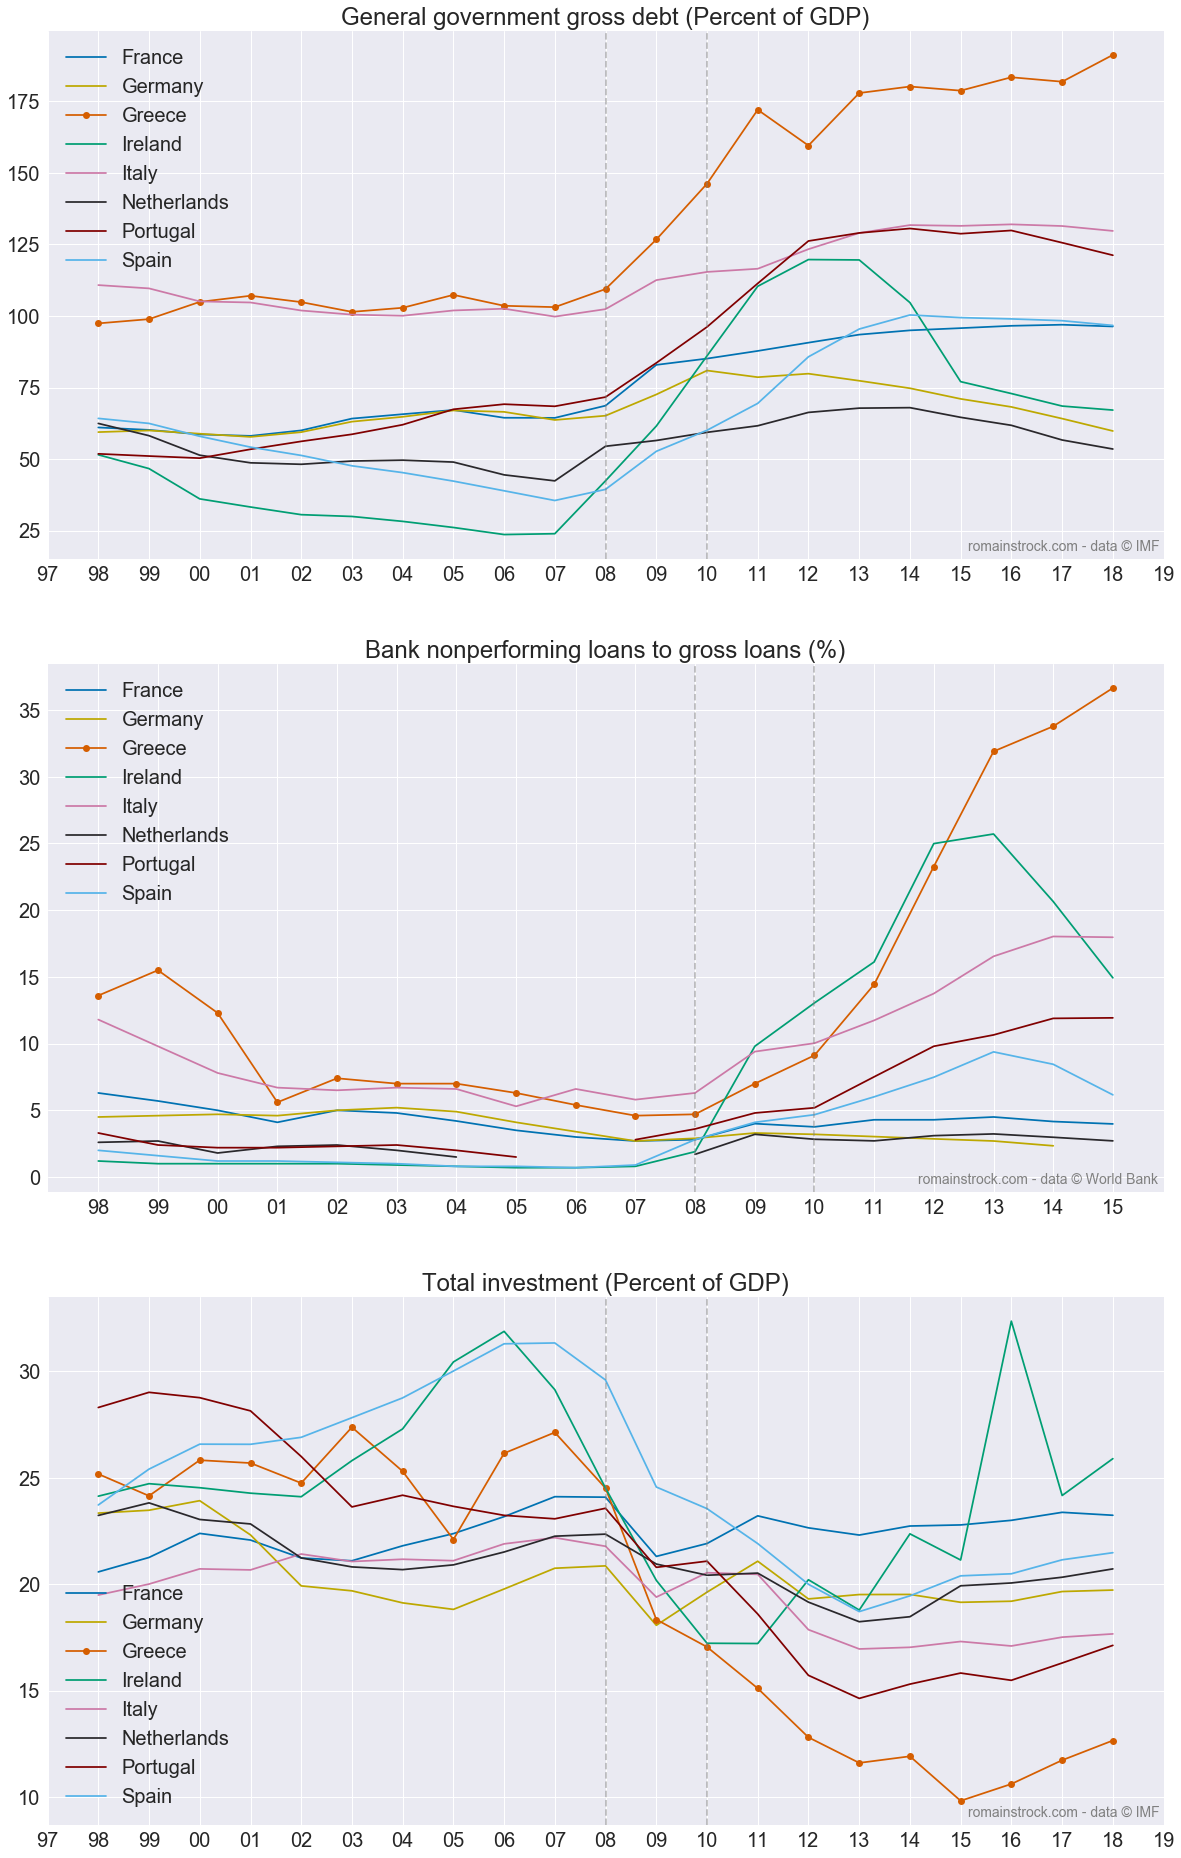

In [151]:
plot_indicators(data, main_indicators, countries)

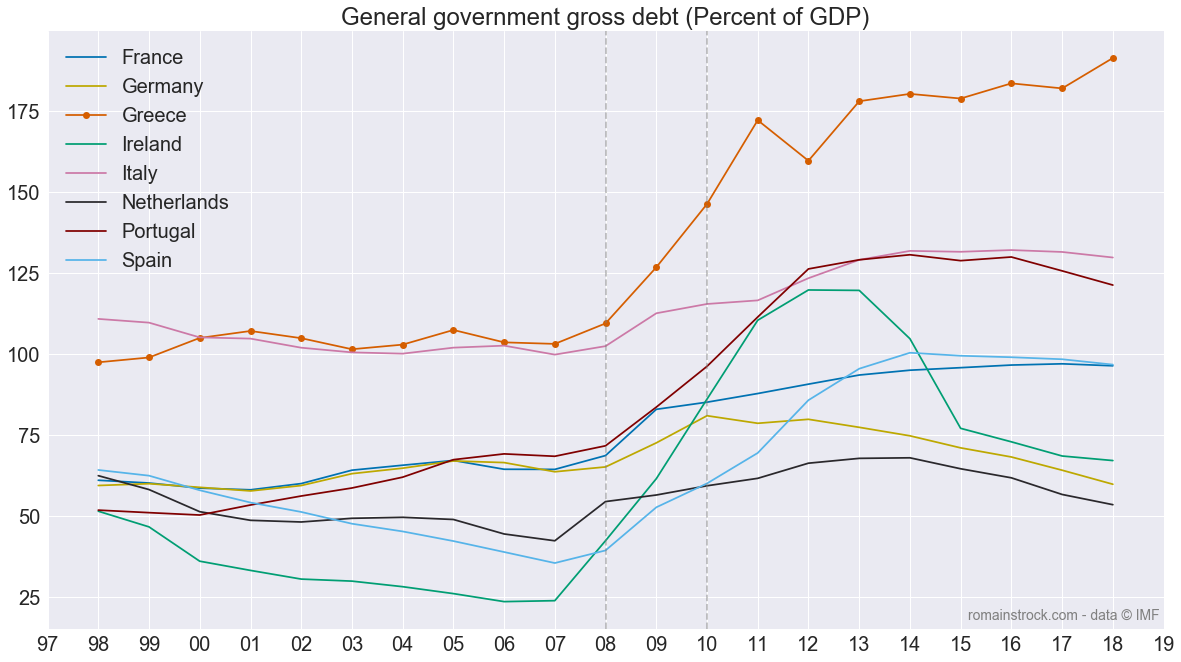

In [152]:
plot_indicators(data, [main_indicators[0]], countries)

## Austerity

In [153]:
austerity_indicators = ['BCA_NGDPD', 'GC.TAX.TOTL.GD.ZS', 'GGR_NGDP', 'GGX_NGDP', 'PCPIPCH']
austerity_data = get_data(austerity_indicators)

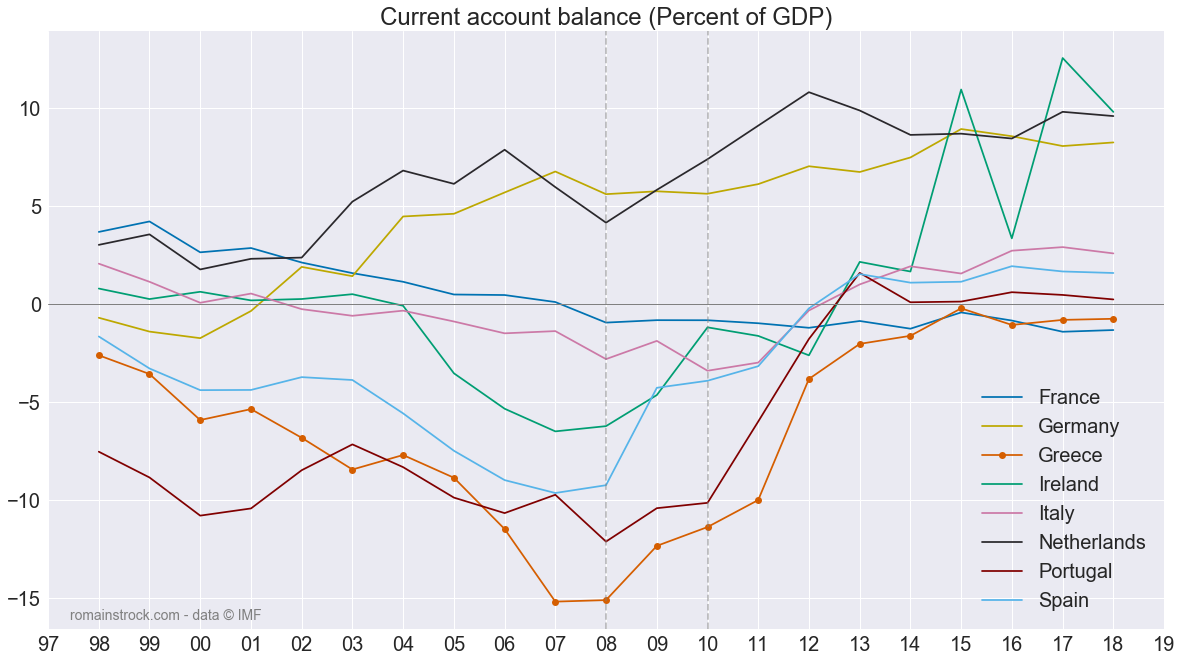

In [157]:
plot_indicators(austerity_data, [austerity_indicators[0]], countries)

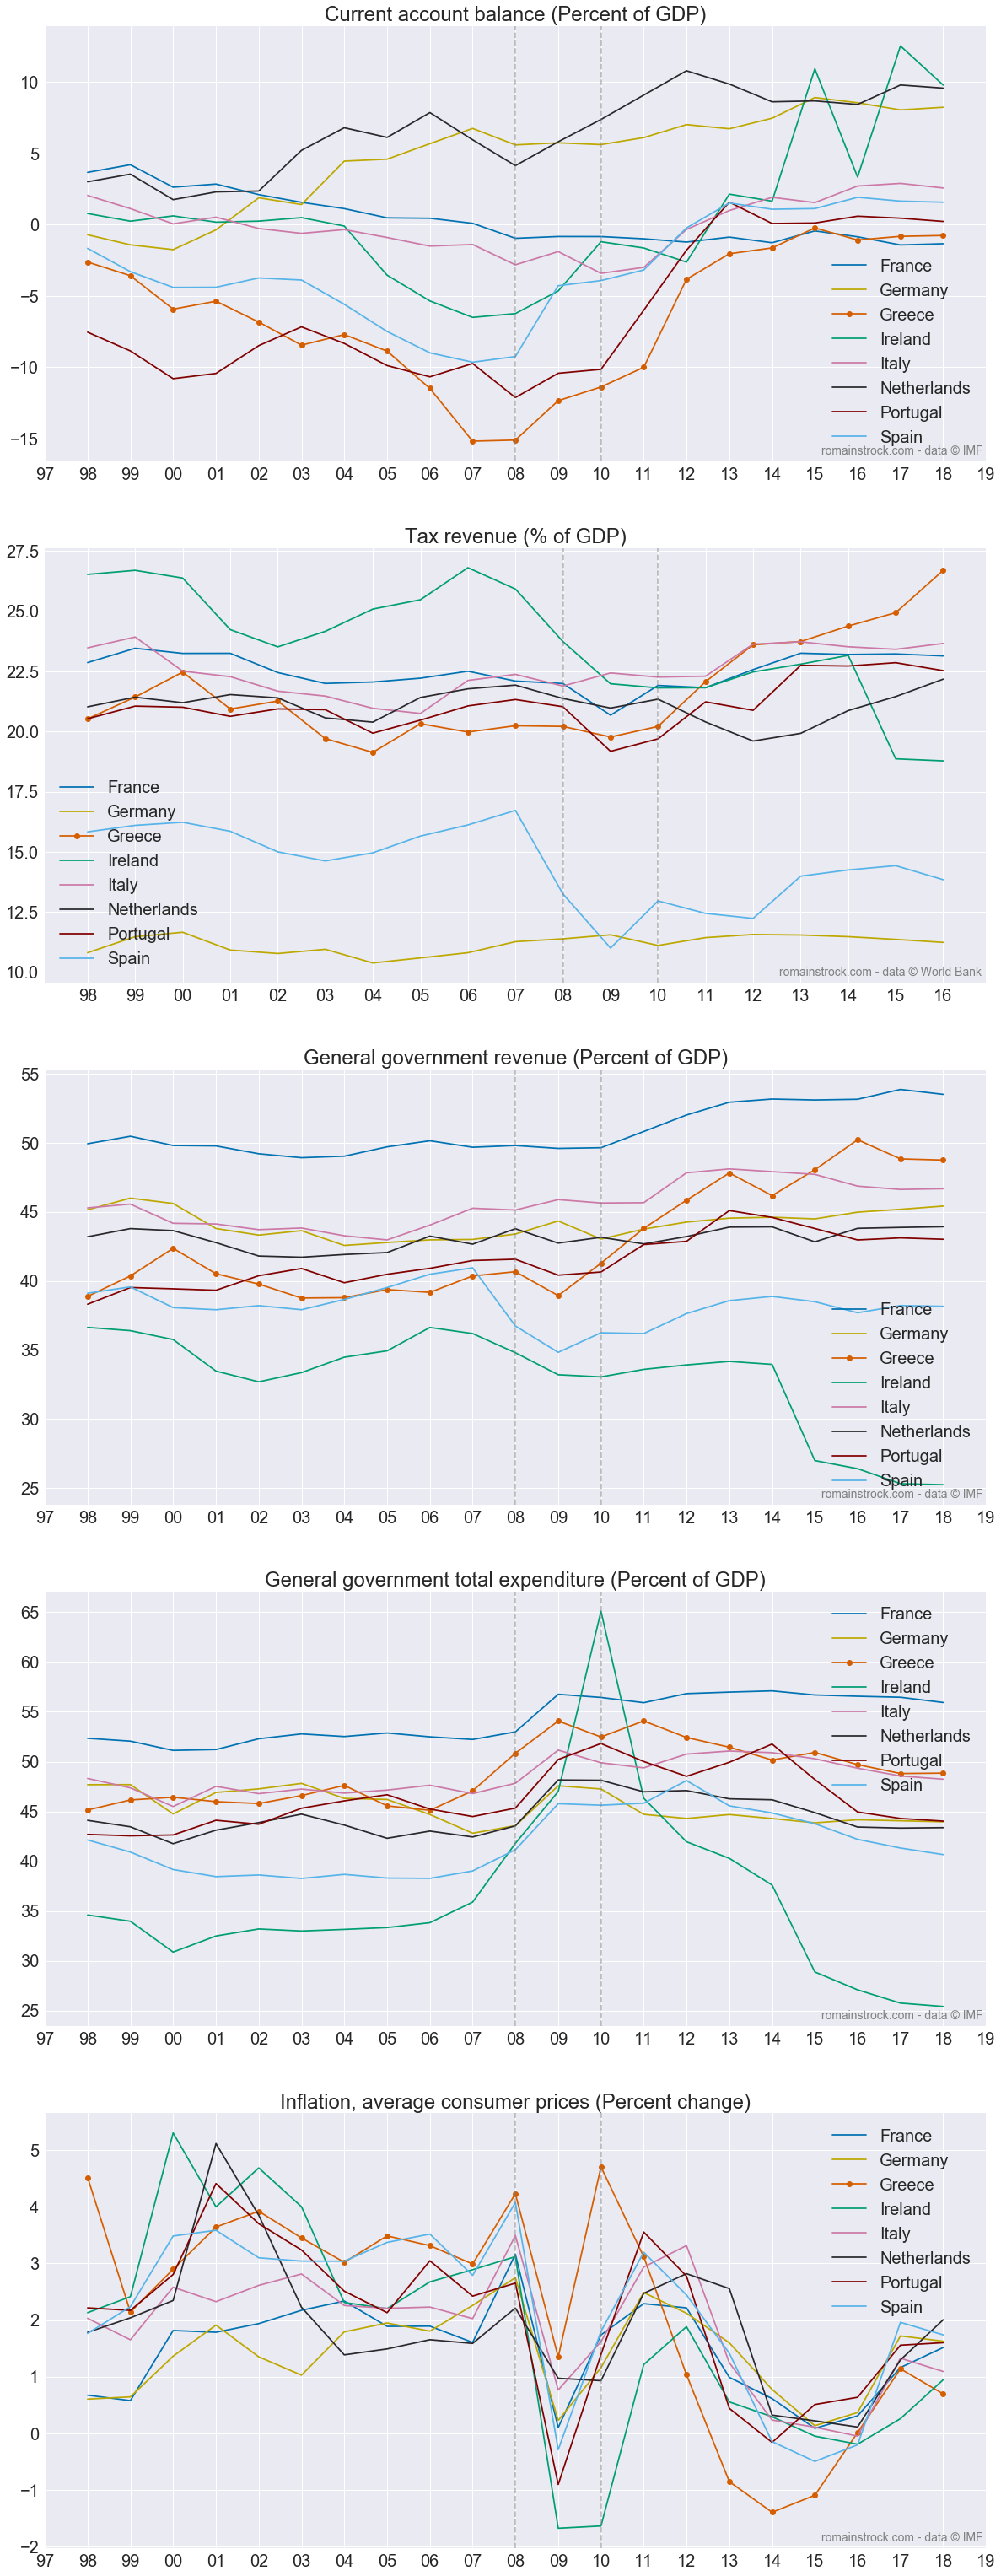

In [155]:
plot_indicators(austerity_data, austerity_indicators, countries)